In [369]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import datetime as dt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel

In [444]:
#pd.read_json('ultimate_data_challenge.json', encoding='latin-1', )
#pd.read_json('logins.json')
with open('ultimate_data_challenge.json') as datafile:
    data=json.load(datafile)
df = pd.DataFrame(data)
with open('logins.json') as datafile:
    data2=json.load(datafile)
logins = pd.DataFrame(data2)
logins

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21
...,...
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38


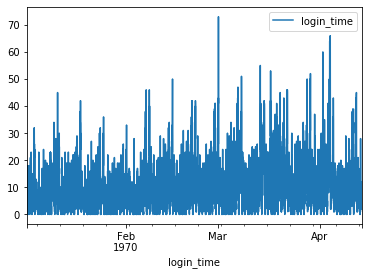

In [445]:
#15 minute time interval shows certain peaks and increases th
logins = logins.apply(pd.to_datetime)
logins.index = logins['login_time']
logins.groupby(pd.Grouper(freq='15Min')).count().plot()
plt.show()
#logins.groupby(pd.Grouper(freq='1d')).count().plot()
#plt.show()

#logins.resample('15T').sum()
#logins

In [446]:
#Login times steadily increase with each month. Peaks can be shown during the weekends of each weak
logins.groupby(pd.Grouper(freq='1m')).count()

,login_time
login_time,
1970-01-31,21239
1970-02-28,24673
1970-03-31,33723
1970-04-30,13507


In [451]:
logins.groupby(pd.Grouper(freq='1d')).count().head(50)

,login_time
login_time,
1970-01-01,112
1970-01-02,681
1970-01-03,793
1970-01-04,788
1970-01-05,459
1970-01-06,536
1970-01-07,648
1970-01-08,625
1970-01-09,881


## Part 2

1. Possible metrics of success would be average profits per week for drivers, average driver partners available to Gotham and Metropolis customers, or surge percentage. 

    Upticks in profits would imply more business for drivers because the access between the two cities. On the consumer side, availability of driver partners would increase if there are more drivers. I think the best approach would be to measure the average surge percentage before or after, since surge pricing happens when there are not enough drivers/high demand in an area. Since there are no changes to demand, this could be used as a measure of supply. 


2. I would implement the experiment by enacting the reimbursed toll costs among drivers for a cost for a whole quarter and compare it to the data(if available) from the same time last year. I would measure the average surge percentage and average surge multiplier before/after and use a t-test to compare the populations. If the surge time percentage and average surge multiplier went down, I could assume that the results of the experiment went as expected, and provide recommendations to implememnt the policy to drive down costs for consumers. 

In [144]:
df.columns

Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver'],
      dtype='object')

In [157]:
df[df.avg.isna() == True]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
90,Winterfell,1,2014-01-10,5.0,1.0,2014-02-09,iPhone,0.0,False,0.0,6.28,NaN
274,Astapor,1,2014-01-25,2.0,4.0,2014-02-09,iPhone,100.0,False,0.0,6.00,NaN
277,Winterfell,1,2014-01-25,NaN,1.0,2014-01-26,iPhone,0.0,False,0.0,1.82,NaN
536,Winterfell,1,2014-01-18,5.0,1.0,2014-02-08,Android,0.0,False,100.0,1.41,NaN
857,Winterfell,0,2014-01-11,4.0,1.0,2014-03-16,iPhone,0.0,False,0.0,0.42,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
49249,King's Landing,0,2014-01-14,5.0,1.0,2014-06-19,iPhone,0.0,True,100.0,4.60,NaN
49376,Astapor,1,2014-01-20,4.0,1.0,2014-01-24,iPhone,0.0,False,100.0,3.01,NaN
49504,Winterfell,2,2014-01-24,5.0,1.0,2014-01-25,Android,0.0,False,100.0,0.75,NaN
49599,King's Landing,1,2014-01-14,5.0,1.0,2014-02-08,iPhone,0.0,False,100.0,2.48,NaN


In [168]:
df.avg_rating_of_driver.value_counts()

5.0    20771
4.0     4193
4.5     2498
4.8     2430
4.7     1945
4.9     1771
4.3     1487
4.6     1143
3.0     1003
4.4      829
4.2      601
3.5      488
3.8      428
4.1      398
3.7      364
1.0      256
3.9      255
2.0      209
3.3      201
3.6      172
3.4      108
2.5       94
3.2       53
2.7       47
3.1       39
2.8       28
2.3       22
2.9       13
2.6       12
2.1        6
1.5        4
2.4        3
1.8        2
1.7        2
2.2        1
1.6        1
1.9        1
Name: avg_rating_of_driver, dtype: int64

In [279]:
df

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained_user
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17 00:00:00,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05 00:00:00,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07 00:00:00,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29 00:00:00,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15 00:00:00,Android,11.8,False,82.4,3.13,4.9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05 00:00:00,iPhone,0.0,False,100.0,5.63,4.2,1
49996,Astapor,1,2014-01-24,5.0,1.00,2014-01-25 00:00:00,iPhone,0.0,False,0.0,0.00,4.0,0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22 00:00:00,Android,0.0,True,100.0,3.86,5.0,0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15 00:00:00,iPhone,0.0,False,100.0,4.58,3.5,0


In [187]:
def fill_missing_values(column_name):
    prob = list(df[column_name].value_counts(normalize=True).values)
    names = list(df[column_name].value_counts(normalize=True).index)
    nan_list = list(df[df[column_name].isna() == True].index)
    for i in nan_list:
        df[column_name][i] = np.random.choice(names, p=prob)

In [281]:
#Change signup_date and last_trip_date to datetime objects.
for i in range(len(df.last_trip_date)):
    df.last_trip_date[i] = df.last_trip_date[i].replace('-','')
    df.last_trip_date[i] = pd.to_datetime(df.last_trip_date[i])

for i in range(len(df.signup_date)):
    df.signup_date[i] = df.signup_date[i].replace('-','')
    df.signup_date[i] = pd.to_datetime(df.signup_date[i])

C:\Users\khaiv\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\khaiv\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\khaiv\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\khaiv\Ana

In [287]:
df

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained_user
0,King's Landing,4,2014-01-25 00:00:00,4.7,1.10,2014-06-17 00:00:00,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29 00:00:00,5.0,1.00,2014-05-05 00:00:00,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06 00:00:00,4.3,1.00,2014-01-07 00:00:00,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10 00:00:00,4.6,1.14,2014-06-29 00:00:00,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27 00:00:00,4.4,1.19,2014-03-15 00:00:00,Android,11.8,False,82.4,3.13,4.9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25 00:00:00,5.0,1.00,2014-06-05 00:00:00,iPhone,0.0,False,100.0,5.63,4.2,1
49996,Astapor,1,2014-01-24 00:00:00,3.0,1.00,2014-01-25 00:00:00,iPhone,0.0,False,0.0,0.00,4.0,0
49997,Winterfell,0,2014-01-31 00:00:00,5.0,1.00,2014-05-22 00:00:00,Android,0.0,True,100.0,3.86,5.0,0
49998,Astapor,2,2014-01-14 00:00:00,3.0,1.00,2014-01-15 00:00:00,iPhone,0.0,False,100.0,4.58,3.5,0


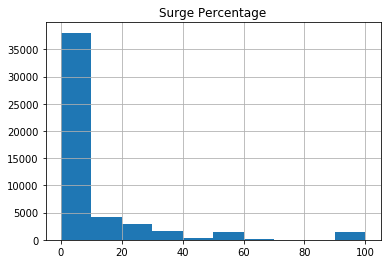

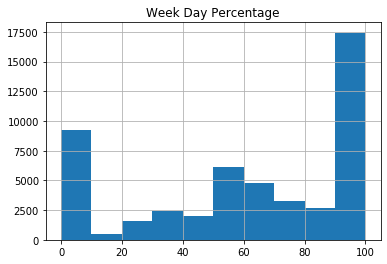

Text(0.5, 1.0, 'Average Distance')

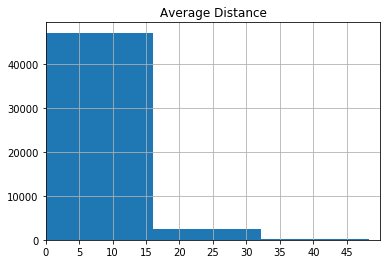

In [441]:
#Generally, riders tend to ride when there is no surge pricing and tend to use it during the weekday.
df['surge_pct'].hist()
plt.title('Surge Percentage')
plt.show()
plt.title('Week Day Percentage')
df['weekday_pct'].hist()
plt.show()
df['avg_dist'].hist()
plt.xlim(0, 50)
plt.xticks(np.arange(0, 50, step=5))
plt.title('Average Distance')

In [288]:
#check which columns have nan values
nan_names = []
for col in df:
    if len(df[df[col].isna() == True]) >= 1:
        nan_names.append(col)

#fill nans in those columns
for n in nan_names:
    fill_missing_values(n)


In [284]:
low = df.last_trip_date.max() - dt.timedelta(30)
retained_user = []
for i in range(len(df)):
    if (df.last_trip_date[i] <= df.last_trip_date.max()) and df.last_trip_date[i] >= low:
        retained_user.append(1)
    else:
        retained_user.append(0)
        

In [289]:
#About 37.6% of users are retained users.
df['retained_user'] = retained_user
df['retained_user'].value_counts(normalize=True)

0    0.62392
1    0.37608
Name: retained_user, dtype: float64

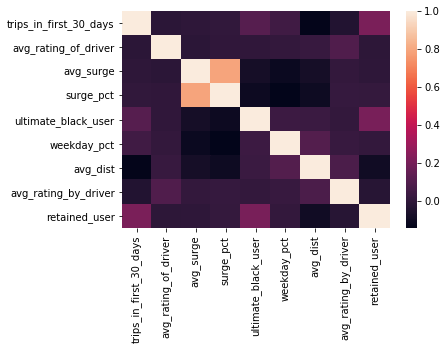

In [290]:
corr = df.corr()
_ = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

In [343]:
active_user = []
for i in range(len(df)):
    if pd.Timedelta(df.last_trip_date[i] - df.signup_date[i]) < dt.timedelta(150):
                    active_user.append(0)
    else:
                    active_user.append(1)
df['active_user'] = active_user

In [344]:
df['active_user'].value_counts()

0    37286
1    12714
Name: active_user, dtype: int64

In [320]:
df['city_cat'] = df['city'].astype('category')
df['city_cat'] = df['city_cat'].cat.codes
df['phone_cat'] = df['phone'].astype('category')
df['phone_cat'] = df['phone_cat'].cat.codes
df.columns

Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'retained_user', 'active_user', 'city_cat',
       'phone_cat'],
      dtype='object')

In [321]:
df_cat = df[['trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'surge_pct', 'ultimate_black_user', 'weekday_pct', 
        'avg_dist', 'avg_rating_by_driver', 'retained_user', 'active_user', 'city_cat',
       'phone_cat']]

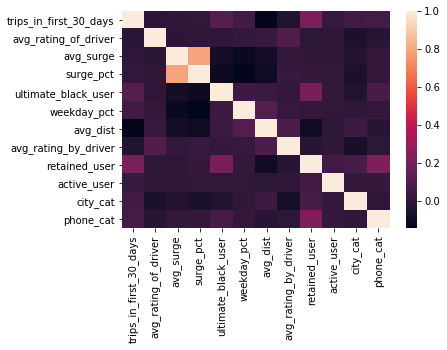

In [345]:
#No feature is very correlated to one another.
corr = df_cat.corr()
_ = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

In [400]:
X = df_cat.drop(['signup_date','last_trip_date','active_user'], axis=1)
y = df_cat['active_user']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('R^2: {}'.format(model.score(X_test, y_test)))
print('Root Mean Squared Error: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))

C:\Users\khaiv\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


R^2: 0.9987
Root Mean Squared Error: 0.03605551275463989


In [401]:
parameters = {'max_depth': list(range(1,30)),
              'n_estimators': list(range(1,30)),
              'max_features': list(range(1,12))
                            
}

model_cv = GridSearchCV(model, parameters, cv=3)
model_cv.fit(X_train, y_train)
print('Tuned Random Forest Classification Parameters: {}'.format(model_cv.best_params_))
print('Best score is {}'.format(model_cv.best_score_))

Tuned Random Forest Classification Parameters: {'max_depth': 9, 'max_features': 11, 'n_estimators': 3}
Best score is 0.998225


In [404]:
print('R^2: {}'.format(model_cv.score(X_test, y_test)))
y_pred_cv = model_cv.predict(X_test)
rmse= np.sqrt(mean_squared_error(y_test, y_pred_cv))
print('Root Mean Squared Error: {}'.format(rmse))

R^2: 0.9987
Root Mean Squared Error: 0.03605551275463989


In [405]:
from sklearn.metrics import classification_report
target_names = ['Active', 'Inactive']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      Active       1.00      1.00      1.00      9987
    Inactive       0.00      0.00      0.00        13

    accuracy                           1.00     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       1.00      1.00      1.00     10000



C:\Users\khaiv\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [390]:
sel = SelectFromModel(RandomForestClassifier(n_estimators=100))
sel.fit(X_train, y_train)
sel.get_support()
selected_feat = X_train.columns[(sel.get_support())]
print(selected_feat)

Index(['surge_pct', 'weekday_pct', 'avg_dist'], dtype='object')


In [408]:
X = df[selected_feat]
y = df['active_user']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('R^2: {}'.format(model.score(X_test, y_test)))
print('Root Mean Squared Error: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))

C:\Users\khaiv\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


R^2: 0.7405
Root Mean Squared Error: 0.5094114250780012


In [409]:
parameters = {'max_depth': list(range(1,20)),
              'n_estimators': list(range(1,30)),
              'max_features': list(range(1,3))
                            
}

model_cv = GridSearchCV(model, parameters, cv=3)
model_cv.fit(X_train, y_train)
print('Tuned Random Forest Regressor Parameters: {}'.format(model_cv.best_params_))
print('Best score is {}'.format(model_cv.best_score_))

Tuned Random Forest Regressor Parameters: {'max_depth': 10, 'max_features': 2, 'n_estimators': 20}
Best score is 0.780575


In [410]:
print('R^2: {}'.format(model_cv.score(X_test, y_test)))
y_pred_cv = model_cv.predict(X_test)
rmse= np.sqrt(mean_squared_error(y_test, y_pred_cv))
print('Root Mean Squared Error: {}'.format(rmse))

R^2: 0.7866
Root Mean Squared Error: 0.4619523784980439


In [411]:
target_names = ['Active', 'Inactive']
print(classification_report(y_test, y_pred_cv, target_names=target_names))

              precision    recall  f1-score   support

      Active       0.82      0.92      0.87      7435
    Inactive       0.63      0.40      0.49      2565

    accuracy                           0.79     10000
   macro avg       0.73      0.66      0.68     10000
weighted avg       0.77      0.79      0.77     10000



In [454]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred_cv)
cf_matrix

array([[6849,  586],
       [1548, 1017]], dtype=int64)

## Part 3

2. My approach was to create an active users column and give each user either a 0(if inactive) and 1(if active). From there, I used a RandomForestClassifier model to predict which users were active using all of the variables excluding signup dates and last_trip_date. This model ran at an R^2 of .9987, almost perfectly predicting who is an active user and who is not. Since, having more variables can inflate the R^2, I used SelectFromModel to choose the most predictive features, which it chose surge_pct, weekday_pct, and 'avg_dist'. Rerunning the model, I attained a R^2 of 0.7875, slightly worse, but had less doubts about overfitting, using only these 3 variables. It also allows the client to see 3 of the most weighted variables to focus on in order to improve their business. 

3. Ultimate might leverage these insights to improve rider retention by gearing towards policies that would lessen certain factors. For example, if Ultimate can reduce the average surge percentage, i.e add more drivers, they can retain more riders. 